In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import torch


seed = 1712
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.float32) 


In [3]:
batch_size = 32
num_gnn_layers = 3
hidden_channels = 64 # min 32

num_train = 500
num_test = 1000
num_eval = 500

# Centralized
num_epochs_cen = 1000
cen_lr = 2e-3 # 5e-3  the the best results

# Decentralized
num_rounds = 50
num_epochs = 1
eval_round = num_rounds//10

lr = 1e-3 # 2e-2 bad
step_size = num_rounds//2
gamma = 0.5
client_fraction = 0.6


In [4]:
num_ue = 6
num_ap = 30
num_antenna = 1
tau=20; power_f=0.2; D=1; f=1900; Hb=15; Hm=1.65; d0=0.01;d1=0.05;


noise_p = 10**((-203.975+10*np.log10(20*10**6)+9)/10);
rho_d = power_f/noise_p
rho_p = power_f/noise_p

In [5]:
num_clients = num_ap
eval_round = eval_round if eval_round else num_rounds//10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create Data

In [6]:
from Utils.data_gen import create_graph, build_loader
from torch_geometric.loader import DataLoader




In [7]:
import scipy.io
from Utils.data_gen import build_cen_loader, build_decen_loader


file_name = f'dl_data_with_power_10000_{num_ue}_{num_ap}'
mat_data = scipy.io.loadmat('Data/' + file_name + '.mat')
beta_all = mat_data['betas']
gamma_all = mat_data['Gammas']
power_all = mat_data['power']/rho_d
phi_all = mat_data['Phii_cf'].transpose(0, 2, 1)
opt_train_rates = mat_data['R_cf_opt_min'][0]

label_all = power_all

perm = np.random.RandomState(seed).permutation(beta_all.shape[0])
train_idx = perm[:num_train]
test_idx  = perm[num_train: num_train + num_test]


## Decentralized Data
# Beta_all, Phi_all = beta_all[train_idx], phi_all[train_idx]
# train_data = create_graph(Beta_all, Phi_all, beta_mean, beta_std, 'het')
# train_loader = build_loader(train_data, batch_size, seed=seed, drop_last=True)

# Beta_test, Phi_test = beta_all[test_idx], phi_all[test_idx]
# test_data = create_graph(Beta_test, Phi_test, beta_mean, beta_std, 'het')
# test_loader = build_loader(test_data, batch_size, seed=seed, drop_last=True)

train_data, train_loader = build_decen_loader(
        beta_all[train_idx],
        gamma_all[train_idx], 
        phi_all[train_idx],
        batch_size, seed=seed
    )
test_data, test_loader = build_decen_loader(
    beta_all[test_idx], 
    gamma_all[test_idx],
    phi_all[test_idx], 
    batch_size, seed=seed
)

## Centralized Data
train_data_cen, train_loader_cen = build_cen_loader(
    beta_all[train_idx],
    gamma_all[train_idx], 
    phi_all[train_idx],
    batch_size, isShuffle=True
)
test_data_cen, test_loader_cen = build_cen_loader(
    beta_all[test_idx], 
    gamma_all[test_idx],
    phi_all[test_idx], 
    batch_size
)

In [8]:
# Model Meta
ap_dim = train_data_cen[0]['AP'].x.shape[1]
ue_dim = train_data_cen[0]['UE'].x.shape[1]
edge_dim = train_data_cen[0]['down'].edge_attr.shape[1]
tt_meta = [('UE', 'up', 'AP'), ('AP', 'down', 'UE')]
dim_dict = {
    'UE': ue_dim,
    'AP': ap_dim,
    'edge': edge_dim,        
}

# Centralized Model

In [14]:

from Models.GNN import APHetNet

cen_model = APHetNet(
        metadata=tt_meta,
        dim_dict=dim_dict,
        out_channels=hidden_channels,
        num_layers=num_gnn_layers,
        hid_layers=hidden_channels//2,
    ).to(device)
torch.nn.utils.clip_grad_norm_(cen_model.parameters(), 1.0)
# cen_optimizer = torch.optim.Adam(cen_model.parameters(), lr=cen_lr)
cen_optimizer = torch.optim.AdamW(
    cen_model.parameters(), lr=cen_lr, weight_decay=1e-4
)


cen_scheduler = torch.optim.lr_scheduler.StepLR(
    cen_optimizer, step_size=num_epochs_cen//10, gamma=0.8
)

In [ ]:
from Utils.centralized_train import cen_eval, cen_train, cen_loss_function


all_rate = []
all_rate_test = []
eval_epochs_cen = num_epochs_cen//10 if num_epochs_cen//10 else 1
print(f'Training Centralized GNN for benchmark...')
print(f'Optimal rate: train {np.mean(opt_train_rates[train_idx])}, test {np.mean(opt_train_rates[test_idx])}')
for epoch in range(num_epochs_cen):
    cen_model.train()
    train_loss = cen_train(
        epoch/(2*num_epochs_cen//3),
        train_loader_cen, cen_model, cen_optimizer,
        tau=tau, rho_p=rho_p, rho_d=rho_d, num_antenna=num_antenna
    )
    
    cen_model.eval()
    with torch.no_grad():
        train_eval = cen_eval(
            train_loader_cen, cen_model,
            tau=tau, rho_p=rho_p, rho_d=rho_d, num_antenna=num_antenna
        )   
        test_eval = cen_eval(
            test_loader_cen, cen_model,
            tau=tau, rho_p=rho_p, rho_d=rho_d, num_antenna=num_antenna
        )  
    all_rate.append(train_eval)    
    all_rate_test.append(test_eval)    
    cen_scheduler.step()
    if epoch%eval_epochs_cen==0:
        print(
            f"Epoch {epoch+1:03d}/{num_epochs_cen} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Train Rate: {train_eval:.4f} | "
            f"Test Rate: {test_eval:.4f} "
        )

Training Centralized GNN for benchmark...
Optimal rate: train 1.7666820771009086, test 1.7480503162157925
Epoch 001/1000 | Train Loss: -1.1372 | Train Rate: 1.3514 | Test Rate: 1.3399 
Epoch 101/1000 | Train Loss: -1.6667 | Train Rate: 1.7117 | Test Rate: 1.6797 
Epoch 201/1000 | Train Loss: -1.6831 | Train Rate: 1.7298 | Test Rate: 1.6956 
Epoch 301/1000 | Train Loss: -1.6939 | Train Rate: 1.7390 | Test Rate: 1.7042 
Epoch 401/1000 | Train Loss: -1.6984 | Train Rate: 1.7472 | Test Rate: 1.7091 
Epoch 501/1000 | Train Loss: -1.7027 | Train Rate: 1.7507 | Test Rate: 1.7103 
Epoch 601/1000 | Train Loss: -1.7072 | Train Rate: 1.7507 | Test Rate: 1.7119 
Epoch 701/1000 | Train Loss: -1.7093 | Train Rate: 1.7561 | Test Rate: 1.7136 
Epoch 801/1000 | Train Loss: -1.7102 | Train Rate: 1.7542 | Test Rate: 1.7133 
Epoch 901/1000 | Train Loss: -1.7127 | Train Rate: 1.7635 | Test Rate: 1.7193 


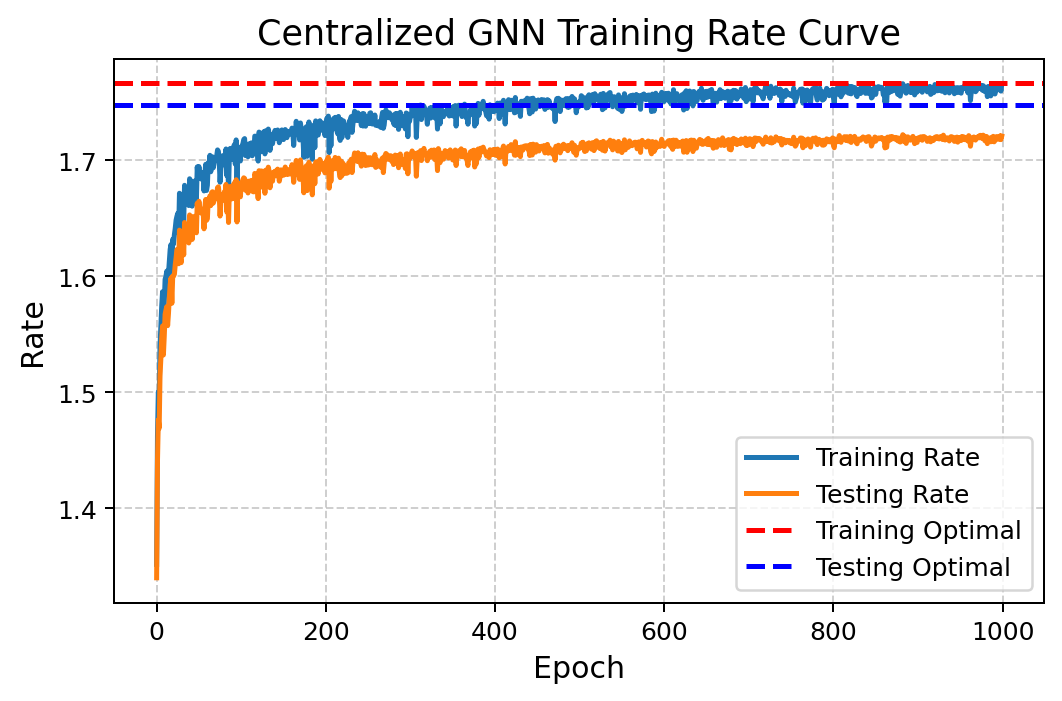

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4), dpi=180)
plt.plot(all_rate, label='Training Rate', linewidth=2)
plt.plot(all_rate_test, label='Testing Rate', linewidth=2)
plt.axhline(y=np.mean(opt_train_rates[train_idx]), linewidth=2, color='r', linestyle='--', label='Training Optimal')
plt.axhline(y=np.mean(opt_train_rates[test_idx]), linewidth=2, color='b', linestyle='--', label='Testing Optimal')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.title('Centralized GNN Training Rate Curve', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# FL GNN

In [9]:
ap_dim = train_data[0][0]['AP'].x.shape[1]
ue_dim_original = train_data[0][0]['UE'].x.shape[1]  # Original UE dim (tau)
edge_dim = train_data[0][0]['down'].edge_attr.shape[1]

# FL model expects augmented UE features: [tau + 3]
# where +3 = DS_global + PC_global + UI_global
ue_dim_fl = ue_dim_original

tt_meta = [('UE', 'up', 'AP'), ('AP', 'down', 'UE')]
dim_dict = {
    'UE': ue_dim_fl,  # Augmented UE dimension
    'AP': ap_dim,
    'edge': edge_dim,
}

In [10]:
from Models.GNN import APHetNetFL
global_model = APHetNetFL(
        metadata=tt_meta,
        dim_dict=dim_dict,
        out_channels=hidden_channels,
        num_layers=num_gnn_layers,
        hid_layers=hidden_channels//2,
    ).to(device)

local_models, optimizers, schedulers = [], [], []
for _ in range(num_clients):
    model = APHetNetFL(
        metadata=tt_meta,
        dim_dict=dim_dict,
        out_channels=hidden_channels,
        num_layers=num_gnn_layers,
        hid_layers=hidden_channels//2,
    ).to(device)
    model.load_state_dict(global_model.state_dict())
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), weight_decay=1e-4)
    local_models.append(model)
    optimizers.append(optimizer)




In [11]:
from Utils.decentralized_train import get_global_info, FedAvg, server_return, fl_train

fed = FedAvg(client_fraction=client_fraction)

send_to_server = get_global_info(
    train_loader, local_models,
    tau=tau, rho_p=rho_p, rho_d=rho_d,
    num_antenna=num_antenna
)

# response_from_server = server_return(train_loader, send_to_server)


In [77]:
globalInformation = send_to_server
dataLoader = train_loader

In [29]:
num_client = len(globalInformation)
response_all = []

for batch_idx, (all_loader, all_response) in enumerate(zip(zip(*dataLoader), zip(*globalInformation))): 
    aug_batch_list = []
    all_client_embeddings = [r['UE'] for r in all_response]
    all_DS = torch.stack([r['DS'][:,0,:] for r in all_response], dim=1).mean(dim=1).reshape(-1,1)
    all_PC = torch.stack([r['PC'][:,0,:] for r in all_response], dim=1).sum(dim=2).mean(dim=1).reshape(-1,1)
    all_UI = torch.stack([r['UI'][:,0,:] for r in all_response], dim=1).sum(dim=2).mean(dim=1).reshape(-1,1)

    if not all(x.shape == all_client_embeddings[0].shape for x in all_client_embeddings):
        raise RuntimeError(f"Batch {batch_idx}: Mismatch in UE counts between clients. Cannot stack.")
    
    global_ue_context = torch.mean(torch.stack(all_client_embeddings), dim=0)
    
    for client_id, (response, batch) in enumerate(zip(all_response, all_loader)):
        other_pack = []
        keys_needed = ['DS', 'PC', 'UI']
        for j in range(num_client):
            if j != client_id:
                full_data = all_response[j]
                filtered_data = {k: full_data[k] for k in keys_needed}
                other_pack.append(filtered_data)

        aug_batch = batch.clone()
        print(aug_batch[(('AP', 'down', 'UE'))])
        prin
        new_ue_features = global_ue_context.to(aug_batch['UE'].x.device)
        aug_batch['UE'].x = torch.cat(
            [
                aug_batch['UE'].x, new_ue_features, 
                all_DS, all_PC, all_UI
            ], 
            dim=-1
        )  

        client_data = {
            'loader': aug_batch,
            'rate_pack': other_pack
        }
        aug_batch_list.append(client_data)
    response_all.append(aug_batch_list)

{'edge_index': tensor([[  0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   1,   1,   2,   2,
           2,   2,   2,   2,   3,   3,   3,   3,   3,   3,   4,   4,   4,   4,
           4,   4,   5,   5,   5,   5,   5,   5,   6,   6,   6,   6,   6,   6,
           7,   7,   7,   7,   7,   7,   8,   8,   8,   8,   8,   8,   9,   9,
           9,   9,   9,   9,  10,  10,  10,  10,  10,  10,  11,  11,  11,  11,
          11,  11,  12,  12,  12,  12,  12,  12,  13,  13,  13,  13,  13,  13,
          14,  14,  14,  14,  14,  14,  15,  15,  15,  15,  15,  15,  16,  16,
          16,  16,  16,  16,  17,  17,  17,  17,  17,  17,  18,  18,  18,  18,
          18,  18,  19,  19,  19,  19,  19,  19,  20,  20,  20,  20,  20,  20,
          21,  21,  21,  21,  21,  21,  22,  22,  22,  22,  22,  22,  23,  23,
          23,  23,  23,  23,  24,  24,  24,  24,  24,  24,  25,  25,  25,  25,
          25,  25,  26,  26,  26,  26,  26,  26,  27,  27,  27,  27,  27,  27,
          28,  28,  28,  28,  28,  28

NameError: name 'prin' is not defined

In [74]:
aug_batch.num_graphs

32

In [68]:
all_client_embeddings = torch.stack([r['UE'] for r in all_response])
all_AP_embeddings = torch.stack([r['AP'] for r in all_response], dim=0)


aug_batch = batch.clone()

client_id = 0

new_ue_features = torch.mean(all_client_embeddings, dim=0)
gap_features = torch.cat([all_AP_embeddings[:client_id],all_AP_embeddings[client_id+1:]], dim=0)
gap_features = torch.sum(gap_features, dim=0) # Sum all AP? 

In [ ]:
aug_batch['GAP'].x = gap_features.to(device)

batch_size = 

In [93]:
from Utils.decentralized_train import server_return_with_gap

response = server_return_with_gap(dataLoader, globalInformation)

In [92]:
response[0][0]['loader'][('UE','up','GAP')].edge_attr.shape

torch.Size([192, 6])

In [95]:
response[0][0]['loader']['UE'].x[0]

tensor([-3.8901e-02, -1.5870e-01, -2.1582e-01, -1.3273e-01,  1.9242e-01,
        -5.9518e-02,  1.2049e-01, -3.4013e-01,  2.2194e-01, -3.8684e-01,
         3.5365e-01,  7.8726e-02,  1.5018e-01, -6.6333e-02,  3.1648e-01,
         3.9642e-01,  2.4589e-01, -4.6441e-02, -2.0831e-01,  1.3376e-01,
        -3.8901e-02, -1.5870e-01, -2.1582e-01, -1.3273e-01,  1.9242e-01,
        -5.9518e-02,  1.2049e-01, -3.4013e-01,  2.2194e-01, -3.8684e-01,
         3.5365e-01,  7.8726e-02,  1.5018e-01, -6.6333e-02,  3.1648e-01,
         3.9642e-01,  2.4589e-01, -4.6441e-02, -2.0831e-01,  1.3376e-01,
         1.1673e+00,  1.4528e-01,  5.3857e-01,  4.0965e-01,  1.6630e-02,
         2.7206e+00,  3.9062e-01,  5.8622e-01,  6.8210e-01, -2.8773e-02,
         1.3518e+00,  1.1759e+00, -1.1487e-01, -9.9417e-02,  1.2164e+00,
         9.3951e-02, -2.4201e-01,  7.2085e-01,  1.3169e+00,  9.1842e-01,
         8.9167e-01,  1.1864e+00,  8.0157e-01,  4.6358e-01,  6.7713e-01,
         1.5142e+00,  2.3757e+00,  1.9164e+00,  2.4

In [150]:
## Train local models
local_weights = []
local_gradients = []
total_loss = 0.0
total_rate = 0.0
selected_clients = fed.sample_clients(num_clients)

for client_idx, (model, opt, client_data_tuple) in enumerate(zip(local_models, optimizers, zip(*response_from_server))):
    batches = [item['loader'] for item in client_data_tuple]
    batch_rate = [item['rate_pack'] for item in client_data_tuple]

    for epoch in range(num_epochs):
        train_loss, train_min, local_gradient = fl_train(
                batches, 
                batch_rate,
                model, opt,
                tau=tau, rho_p=rho_p, rho_d=rho_d,
                num_antenna=num_antenna,
                # epochRatio=round/(2*4/3),
            )


In [ ]:
from Utils.decentralized_train import fl_eval
from Utils.comm import rate_from_component

dataLoader = test_loader
send_to_server = get_global_info(
    dataLoader, local_models,
    tau=tau, rho_p=rho_p, rho_d=rho_d,
    num_antenna=num_antenna
)

all_DS = torch.cat([
    torch.stack([client_data['DS'][:,0,:] for client_data in batch_clients], dim=1)
    for batch_clients in zip(*send_to_server)
], dim=0)

all_PC = torch.cat([
    torch.stack([client_data['PC'][:,0,:] for client_data in batch_clients], dim=1)
    for batch_clients in zip(*send_to_server)
], dim=0)

all_UI = torch.cat([
    torch.stack([client_data['UI'][:,0,:] for client_data in batch_clients], dim=1)
    for batch_clients in zip(*send_to_server)
], dim=0)

rate = rate_from_component(all_DS, all_PC, all_UI, num_antenna)

In [155]:
torch.mean(torch.min(rate, dim=1))

TypeError: mean(): argument 'input' (position 1) must be Tensor, not torch.return_types.min

In [160]:
min_rate, _ = torch.min(rate, dim=1)
torch.mean(min_rate)

tensor(0.6724)